# Network Model - Analysis

In [1]:
# Libraries
import numpy as np
import pandas as pd
import igraph as ig
import networkx as nx
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from auxiliar_funcs import *
import matplotlib.pyplot as plt
#import powerlaw as plaw
import collections
from math import log2, ceil

### Load Data

In [69]:
# Re-order columns by user attributes and resources attributes
user_attr = ['role', 'specialty', 'team', 'uward', 'agentfor']
rsrc_attr = ['type', 'patient', 'treatingteam', 'oward', 'author', 'topic']
print("# User attr:", len(user_attr))
print("# Rsrc attr:", len(rsrc_attr))
print()

##### Load positive access log. #####
url_file = "../00-Data/hc-positive.csv"
df = pd.read_csv(url_file)
df = df[df.columns[:-1]].drop_duplicates()
print("***** POSITIVE HC *****")
print("Columns: ", df.columns)
print("Length: ", len(df))
print(df.info())
print(df.head(5))
print(); print()

##### Load positive access log. #####
url_file = "../00-Data/hc-negative.csv"
df_neg = pd.read_csv(url_file)
df_neg = df_neg[df_neg.columns[:-2]].drop_duplicates()
df_neg = df_neg.replace("?", "none")
df_neg["action"] = 0
print("***** NEGATIVE HC *****")
print("Columns: ", df_neg.columns)
print("Length: ", len(df_neg))
print(df_neg.info())
print(df_neg.head(5))
print(); print()

##### Concatenar solicitudes + y - #####
df_total = pd.concat([df, df_neg])
print("Columns: ", df_total.columns)
print("Length: ", len(df_total))
print()

##### Calcular porcentaje de solicitudes + y - #####
print("% Solicitudes (+): {:.2f}".format((len(df)/len(df_total))*100))
print("% Solicitudes (-): {:.2f}".format((len(df_neg)/len(df_total))*100))
print(); print()

# Cross-Validation
k = 10
test_size = 0.2
kfold = StratifiedShuffleSplit(n_splits=k, test_size=test_size, random_state=1)

data_partition = kfold.split(df_total, df_total.action)
data_corpus = [] # Lista donde se almacenan los k fols

for train_data, test_data in data_partition:        
    X_train, X_test = df_total.iloc[train_data], df_total.iloc[test_data]
    data_corpus.append([X_train, X_test])

print("Hecho!")
print("- k =",k)
print("- Porcentaje Train-Test:", (1-test_size)*100, "-", test_size*100)

print("|U|:", len(df[user_attr].drop_duplicates()))
print("|R|:", len(df[rsrc_attr].drop_duplicates()))

# User attr: 5
# Rsrc attr: 6

***** POSITIVE HC *****
Columns:  Index(['action', 'role', 'type', 'oward', 'uward', 'team', 'treatingteam',
       'patient', 'author', 'topic', 'specialty', 'agentfor'],
      dtype='object')
Length:  8735
<class 'pandas.core.frame.DataFrame'>
Int64Index: 8735 entries, 0 to 8998
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   action        8735 non-null   int64 
 1   role          8735 non-null   object
 2   type          8735 non-null   object
 3   oward         8735 non-null   object
 4   uward         8735 non-null   object
 5   team          8735 non-null   object
 6   treatingteam  8735 non-null   object
 7   patient       8735 non-null   object
 8   author        8735 non-null   object
 9   topic         8735 non-null   object
 10  specialty     8735 non-null   object
 11  agentfor      8735 non-null   object
dtypes: int64(1), object(11)
memory usage: 887.1+ KB
None
   actio

In [3]:
id_kfold = 0

df_train_k, df_test_k = data_corpus[id_kfold][0], data_corpus[id_kfold][1]
print("# Solicitudes Train:", len(df_train_k), " %: {:.2f}".format((len(df_train_k)/(len(df_train_k)+len(df_test_k)))*100))
print("# Solicitudes Test:", len(df_test_k), " %: {:.2f}".format((len(df_test_k)/(len(df_train_k)+len(df_test_k)))*100))
print("# Solicitudes:", len(df_train_k)+len(df_test_k))
print()

##### ***** TAREA 1: Tratar valores desconocidos y nulos ***** #####
print("Tarea 1: Tratar valores desconocidos y nulos.")
# Cambiar valores string a numeros
mapping = {"none": 10, "doctor": 11, "nurse": 12} # role
df_train_k["role"] = df_train_k["role"].replace(mapping)
df_test_k["role"] = df_test_k["role"].replace(mapping)

mapping = {"note": 110, "cardiology": 111, "nursing": 112, "oncology": 113, "none": 114} # speacialty
df_train_k["specialty"] = df_train_k["specialty"].replace(mapping)
df_test_k["specialty"] = df_test_k["specialty"].replace(mapping)

mapping = {"oncteam1": 1101, "carteam1": 1111,
           "carteam2": 1121, "oncteam2": 1131, "none": 1141} # tem
df_train_k["team"] = df_train_k["team"].replace(mapping)
df_test_k["team"] = df_test_k["team"].replace(mapping)

mapping = {"carward": 11011, "oncward": 11111, "none": 11211} # uward
df_train_k["uward"] = df_train_k["uward"].replace(mapping)
df_test_k["uward"] = df_test_k["uward"].replace(mapping)

mapping = {"oncpat1": 111011, "carpat1": 111111, # agentfor
           "oncpat2": 111211, "carpat2": 111311, "none": 111411}
df_train_k["agentfor"] = df_train_k["agentfor"].replace(mapping)
df_test_k["agentfor"] = df_test_k["agentfor"].replace(mapping)

mapping = {"hr": 1110111, "hritem": 1111111} # type
df_train_k["type"] = df_train_k["type"].replace(mapping)
df_test_k["type"] = df_test_k["type"].replace(mapping)

mapping = {"oncpat1": 211012, "carpat1": 211112, # patient
           "oncpat2": 211212, "carpat2": 211312, "none": 211412}
df_train_k["patient"] = df_train_k["patient"].replace(mapping)
df_test_k["patient"] = df_test_k["patient"].replace(mapping)

mapping = {"oncteam1": 2102, "carteam1": 2112,
           "carteam2": 2122, "oncteam2": 2132, "none": 2142} # treatingteam
df_train_k["treatingteam"] = df_train_k["treatingteam"].replace(mapping)
df_test_k["treatingteam"] = df_test_k["treatingteam"].replace(mapping)

mapping = {"carward": 21012, "oncward": 21112, "none": 21212} # oward
df_train_k["oward"] = df_train_k["oward"].replace(mapping)
df_test_k["oward"] = df_test_k["oward"].replace(mapping)

mapping = {"note": 210, "cardiology": 211, "nursing": 212, "oncology": 213, "none": 214} # topic
df_train_k["topic"] = df_train_k["topic"].replace(mapping)
df_test_k["topic"] = df_test_k["topic"].replace(mapping)

mapping = {"oncdoc2": 11110111, "carnurse1": 11111111, "oncnurse2": 11112111, # author
           "carnurse2": 11113111, "oncdoc1": 11114111, "oncnurse1": 11115111, "none": 11116111}
df_train_k["author"] = df_train_k["author"].replace(mapping)
df_test_k["author"] = df_test_k["author"].replace(mapping)
print("Tarea 1: Hecha!.")
print()

##### ***** TAREA 2: Convertir valores continuas a categoricos ***** #####
print("Tarea 2: No aplica!.")
print()

##### ***** TAREA 3: Eliminar solicitudes duplicadas ***** #####
##### Dataframe solicitudes positivas y negativas #####
print("Tarea 3: Eliminar solicitudes duplicadas.")
df_train_k_pos = df_train_k[df_train_k.action==1]   # Train Pos
df_train_k_neg = df_train_k[df_train_k.action==0]   # Train Neg
df_test_k_pos = df_test_k[df_test_k.action==1]      # Test Pos
df_test_k_neg = df_test_k[df_test_k.action==0]      # Test Neg
df_train_k_pos = df_train_k_pos[df_train_k_pos.columns[1:]].drop_duplicates()
df_train_k_neg = df_train_k_neg[df_train_k_neg.columns[1:]].drop_duplicates()
df_test_k_pos = df_test_k_pos[df_test_k_pos.columns[1:]].drop_duplicates()
df_test_k_neg = df_test_k_neg[df_test_k_neg.columns[1:]].drop_duplicates()
print()

##### Agregar la columna de usuarios y recursos #####
user_dict = get_user_res(df_train_k_pos, user_attr, True)
res_dict = get_user_res(df_train_k_pos, rsrc_attr, False)
df_train_k_pos = add_col(df_train_k_pos, user_dict, user_attr, "USRID")
df_train_k_pos = add_col(df_train_k_pos, res_dict, rsrc_attr, "RESID")
df_train_k_neg = add_col(df_train_k_neg, user_dict, user_attr, "USRID")
df_train_k_neg = add_col(df_train_k_neg, res_dict, rsrc_attr, "RESID")
df_test_k_pos =  add_col(df_test_k_pos, user_dict, user_attr, "USRID")
df_test_k_pos =  add_col(df_test_k_pos, res_dict, user_attr, "RESID")
df_test_k_neg = add_col(df_test_k_neg, user_dict, user_attr, "USRID")
df_test_k_neg = add_col(df_test_k_neg, res_dict, rsrc_attr, "RESID")

print("# Solicitudes Train (+):", len(df_train_k_pos), " %: {:.2f}".format((len(df_train_k_pos)/len(df_train_k))*100))
print("# Solicitudes Train (-):", len(df_train_k_neg), " %: {:.2f}".format((len(df_train_k_neg)/len(df_train_k))*100))
print("# Solicitudes Test (+):", len(df_test_k_pos), " %: {:.2f}".format((len(df_test_k_pos)/len(df_test_k))*100))
print("# Solicitudes Test (-):", len(df_test_k_neg), " %: {:.2f}".format((len(df_test_k_neg)/len(df_test_k))*100))
print("# Train Users (+): ", len(df_train_k_pos.USRID.drop_duplicates()))
print("# Train Resrc (+): ", len(df_train_k_pos.RESID.drop_duplicates()))
print("# Train Users (-): ", len(df_train_k_neg.USRID.drop_duplicates()))
print("# Train Resrc (-): ", len(df_train_k_neg.RESID.drop_duplicates()))
print("# Test Users (+): ", len(df_test_k_pos.USRID.drop_duplicates()))
print("# Test Resrc (+): ", len(df_test_k_pos.RESID.drop_duplicates()))
print("# Test Users (-): ", len(df_test_k_neg.USRID.drop_duplicates()))
print("# Test Resrc (-): ", len(df_test_k_neg.RESID.drop_duplicates()))

# Solicitudes Train: 14186  %: 80.00
# Solicitudes Test: 3547  %: 20.00
# Solicitudes: 17733

Tarea 1: Tratar valores desconocidos y nulos.
Tarea 1: Hecha!.

Tarea 2: No aplica!.

Tarea 3: Eliminar solicitudes duplicadas.


/home/daniel/anaconda3/envs/tesis_env/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/daniel/anaconda3/envs/tesis_env/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/daniel/anaconda3/envs/tesis_env/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde


# Solicitudes Train (+): 6988  %: 49.26
# Solicitudes Train (-): 7197  %: 50.73
# Solicitudes Test (+): 1747  %: 49.25
# Solicitudes Test (-): 1800  %: 50.75
# Train Users (+):  1046
# Train Resrc (+):  2090
# Train Users (-):  1045
# Train Resrc (-):  1239
# Test Users (+):  748
# Test Resrc (+):  1
# Test Users (-):  826
# Test Resrc (-):  407


### Network Modelling

In [4]:
def build_network_model(data, usr_id_name, res_id_name, file_path=None):
    """
    Builds the Access Requests Bipartite Network from Access log.

    Args:
        data (pandas dataframe): The Access Log.
        usr_id_name (str): The name of the ID users column in the Access Log
        res_id_name (str): The name of the ID resources column in the Access Log
    
    Returns:
        Graph (iGraph): The Access Requests Bipartite Network.

    Raises:
        TypeError: If a network is not Bipartite.
    """
    
    list_of_edges = []
    bi_network = nx.Graph() # NetworkX Graph object

    for usr_idx, rsr_idx in data[[usr_id_name, res_id_name]].values:
        list_of_edges.append((int(usr_idx), int(rsr_idx))) # Tuple of edges
    bi_network.add_edges_from(list_of_edges) # Build Network with edges

    # Change networkX object to iGraph object
    bi_network = ig.Graph.from_networkx(bi_network)
    bi_network.vs['name'] = bi_network.vs["_nx_name"] # Clean name column
    del bi_network.vs["_nx_name"] # Remove uncleaned name column

    print(bi_network.summary())
    print(bi_network.vs())

    if not bi_network.is_bipartite():
        raise TypeError("The ARBN is not bipartite")

    ### Add type of node (user or resource)
    list_of_resources_in_data = list(data[res_id_name])
    list_node_type = []
    for node in bi_network.vs():
        if node['name'] in list_of_resources_in_data:
            list_node_type.append(1) # A resource
        else:
            list_node_type.append(0) # An user
    bi_network.vs["typen"] = list_node_type
    ### End node type

    if not file_path == None: # Create a file
        ig.write(bi_network, file_path)

    print("ARBN builded!")
    print(bi_network.summary())
    print("|U-Nodes| =", len(bi_network.vs.select(typen=0)))
    print("|R-Nodes| =", len(bi_network.vs.select(typen=1)))

    return bi_network
    

In [5]:
bip_network = build_network_model(df_train_k_pos, 'USRID', 'RESID')

IGRAPH UN-- 3136 6988 -- 
+ attr: name (v)
ARBN builded!
IGRAPH UN-- 3136 6988 -- 
+ attr: name (v), typen (v)
|U-Nodes| = 1046
|R-Nodes| = 2090


In [66]:
bip_network.write("HC-bip.gml")

### User network

In [70]:
def get_edge_weight(i_node, j_node):
    """
    Compute the weight of an edge between i and j nodes.

    Args:
        i_node (networkX node): i node.
        j_node (networkX node): j node.
    
    Returns:
        weight (float): The weight between nodes.

    Raises:
        TypeError: if there are not an intersection
    """
    neighs_i = set(i_node.neighbors())
    neighs_j = set(j_node.neighbors())

    insersection_neighbors = neighs_i.intersection(neighs_j)
    
    weight = (len(insersection_neighbors)*len(insersection_neighbors)) / (len(neighs_i)*len(neighs_j))

    return weight


def bipartite_projection(biparte_network, node_type=0):
    """
    Generate a monopartite network from bipartite network.

    Parameters:
        bipartite_network (igraph Graph): The bipartie network.
        node_type (int): The set of nodes of the monopartite network.

    Returns:
        Graph (iGraph): The monopartite (projected) network.

    Raises:
        Some
    """

    #Check if the bipartite network is a bipartite network:
    if not biparte_network.is_bipartite():
        raise TypeError("The ARBN is not bipartite")

    # networkX object (more easy to buil)
    g = nx.Graph()

    # All opposite node set
    opposite_nodes = biparte_network.vs.select(typen=0)

    # Check for every node the same type
    for X_node in opposite_nodes:
        # Select all neighbors of the X_node
        neighbordhood = X_node.neighbors()

        for Y_node_i in neighbordhood:
            for Y_node_j in neighbordhood:
                # Ceck if both nodes are the same
                if Y_node_i['name'] != Y_node_j['name']:
                    # If there is no an edge generate
                    if not g.has_edge(Y_node_i['name'], Y_node_j['name']):
                        weight_ = get_edge_weight(Y_node_i, Y_node_j)
                        #print("Peso: ", Y_node_i['name'], "-", Y_node_j['name'], " => ", weight_)
                        g.add_edge(Y_node_i["name"], Y_node_j["name"],
                                   weight=weight_)                                 

    # Convert from networkX graph to igraph graph
    g = ig.Graph.from_networkx(g)
    g.vs["name"] = g.vs["_nx_name"]
    del g.vs["_nx_name"]
    
    return g


In [7]:
user_network = bipartite_projection(bip_network, 0)
print(user_network.summary())
# ig.write(user_network, "graphs/amz_user_network.gml")

IGRAPH UNW- 1032 19509 -- 
+ attr: name (v), weight (e)


In [71]:
user_network = bipartite_projection(bip_network, 0)
print(user_network.summary())
ig.write(user_network, "graphs/hc_test.gml")

IGRAPH UNW- 2076 29286 -- 
+ attr: name (v), weight (e)


In [58]:
# Add features
user_data_attrs = df_train_k_pos[user_attr+["USRID"]].drop_duplicates()
#user_data_attrs[user_data_attrs.USRID == 101]
role_attr = []
specialty_attr = []
team_attr = []
uward_attr = []
agentfor_attr = []
for user in user_network.vs():
    user_row = user_data_attrs[user_data_attrs.USRID == user['name']]    
    role_attr.append(user_row['role'].values[0])
    specialty_attr.append(user_row['specialty'].values[0])
    team_attr.append(user_row['team'].values[0])
    uward_attr.append(user_row['uward'].values[0])
    agentfor_attr.append(user_row['agentfor'].values[0])
    
user_network.vs['role'] = role_attr
user_network.vs['specialty'] = specialty_attr
user_network.vs['team'] = team_attr
user_network.vs['uward'] = uward_attr
user_network.vs['agentfor'] = agentfor_attr
user_network.summary()

'IGRAPH UNW- 1032 19509 -- \n+ attr: agentfor (v), name (v), role (v), specialty (v), team (v), uward (v), weight (e)'

In [67]:
user_data_attrs

,role,specialty,team,uward,agentfor,USRID
1745,10,111,1111,11211,111211,101
2816,12,114,1141,11111,111311,1101
7575,11,111,1111,11111,111011,2101
8573,10,113,1121,11011,111111,3101
1511,11,113,1101,11111,111011,4101
...,...,...,...,...,...,...
5358,12,114,1111,11211,111311,1041101
8884,10,113,1121,11211,111411,1042101
6211,10,110,1141,11111,111411,1043101
5288,11,110,1141,11011,111111,1044101


### Network Analysis

In [59]:
density = user_network.density()
print("Density:", density)

avg_degree = sum(user_network.degree()) / user_network.vcount()
print("Avg. degree", avg_degree)

components = user_network.components()
print("Connected Components:", len(components))

Density: 0.0366713283558523
Avg. degree 37.80813953488372
Connected Components: 1


In [60]:
def calculate_log_binning(degrees_list, n_bins):
    """
    Compute the log-binning y-values.
    """
    current_sum = 0
    previous_k = 0
    y_values_log_bin_list = []
    x_values = []

    for i in range(1, n_bins):
        x_values.append(previous_k)
        current_k = 2 ** (i)
        current_sum = current_sum + current_k
        temp_y_value = sum(degrees_list[previous_k:current_k])
        temp_y_value = temp_y_value / (current_k-previous_k)
        y_values_log_bin_list.append(temp_y_value)
        previous_k = current_k

        if current_sum > len(degrees_list):
            x_values.append(previous_k)
            temp_y_value = sum(degrees_list[previous_k:len(degrees_list)])
            temp_y_value = temp_y_value / (len(degrees_list)-previous_k)
            y_values_log_bin_list.append(temp_y_value)            
            break

    return x_values, y_values_log_bin_list

218


Text(0, 0.5, 'P(k)')

<Figure size 432x288 with 0 Axes>

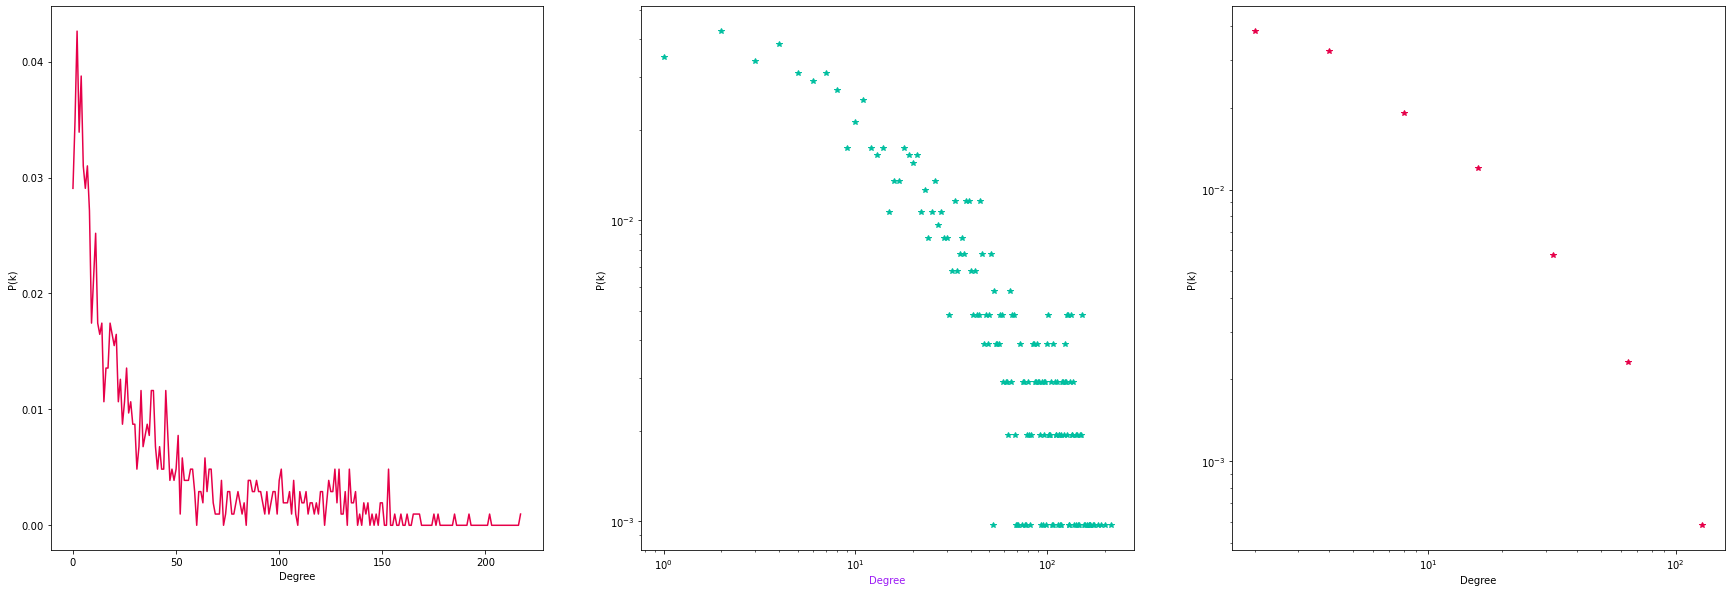

In [61]:
max_degree = max(user_network.degree())
print(max_degree)

# Colors palette CATEGORICAL
# ["#ea5545", "#f46a9b", "#ef9b20", "#edbf33", "#ede15b", "#bdcf32", "#87bc45", "#27aeef", "#b33dc6"]
# ["#fd7f6f", "#7eb0d5", "#b2e061", "#bd7ebe", "#ffb55a", "#ffee65", "#beb9db", "#fdcce5", "#8bd3c7"] Pasteles
# [#e60049", "#0bb4ff", "#50e991", "#e6d800", "#9b19f5", "#ffa300", "#dc0ab4", "#b3d4ff", "#00bfa0"] Dutch

# Colors palette Secquence
# ["#115f9a", "#1984c5", "#22a7f0", "#48b5c4", "#76c68f", "#a6d75b", "#c9e52f", "#d0ee11", "#d0f400"]

# Crear una lista donde se almacena
degree_list = np.zeros(max_degree, dtype=int)

for node in user_network.vs():    
    degree_list[node.degree()-1] = (degree_list[node.degree()-1] + 1)

degree_list = degree_list / user_network.vcount()

plt.clf()
fig = plt.figure(figsize=(30, 10))     

plt.subplot(1, 3, 1)
plt.plot(degree_list, color="#e60049")
plt.xlabel('Degree')
plt.ylabel('P(k)')

plt.subplot(1, 3, 2)
plt.plot(range(max_degree), degree_list, color="#00bfa0", marker='*', ls='None')
plt.loglog()
plt.xlabel('Degree', color='#9b19f5')
plt.ylabel('P(k)')

plt.subplot(1, 3, 3)
n_log_bin = ceil(log2(max(user_network.degree())))
x_values, y_values = calculate_log_binning(degree_list, n_log_bin)
plt.plot(x_values, y_values, color='#e60049', marker="*", ls='None')
#C = y_values[0]
#alpha = 1.4
#x = np.arange(1,len(degree_list))
#y = C*np.power(x,-alpha)
#plt.plot(x, y, "b")
plt.loglog()
plt.xlabel('Degree')
plt.ylabel('P(k)')

#plt.subplot(1, 3, 3)
#bins = np.logspace(0, 3.22, 12)
#plt.plot(bins[:-1], hist_norm, "r*")
#plt.plot(range(max_degree), degree_list, "b.")
#plt.loglog()
#plt.xlabel('Degree')
#plt.ylabel('P(k)')

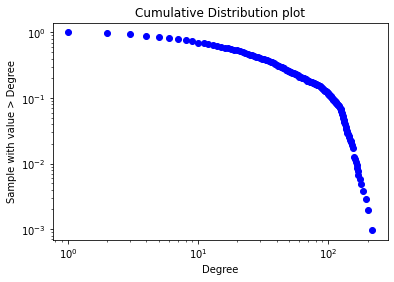

In [11]:
degree_sequence = sorted([d for d in user_network.degree()], reverse=True)  # degree sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())
cs = np.cumsum(np.array(cnt)/user_network.vcount())
plt.loglog(deg, cs, 'bo')
plt.title("Cumulative Distribution plot")
plt.ylabel("Sample with value > Degree")
plt.xlabel("Degree")
plt.show()

### Weighted distribution

1000


<Figure size 432x288 with 0 Axes>

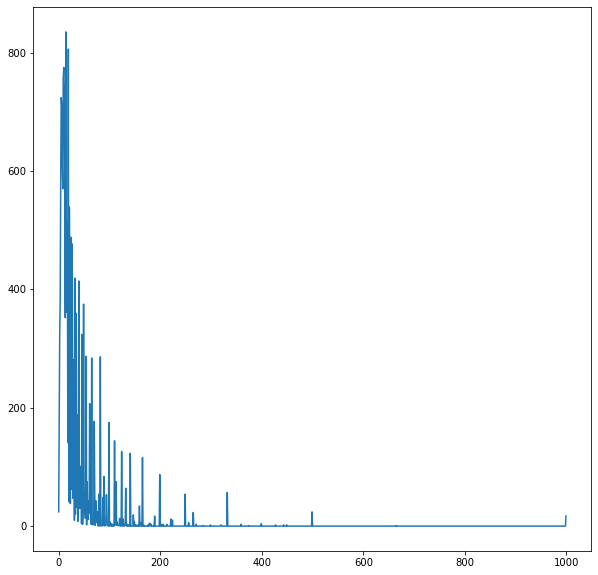

In [12]:
arreglo_test = (np.array(user_network.es['weight'])*1000).astype(int)
max_peso = max(arreglo_test)
print(max_peso)

# Crear una lista donde se almacena
arreglo_test_ = np.zeros(max_peso, dtype=int)

for node in arreglo_test:
    #print(node.degree())
    arreglo_test_[node-1] = (arreglo_test_[node-1] + 1)

plt.clf()
plt.figure(figsize=(10,10))
plt.plot(arreglo_test_)
#fit = powerlaw.Fit(np.array(degree_list)+1, fit_method='KS')#, xmin=xmin, xmax=max(degree)-xmin,discrete=True)
#fit.power_law.plot_pdf(color='r',linestyle='--',label='fit ccdf')
#fit.plot_ccdf()
#plt.yscale("log")
#plt.xscale("log")
plt.show()
print()

P6: Scale-free distribution p(k) = ∼k^{−α}.


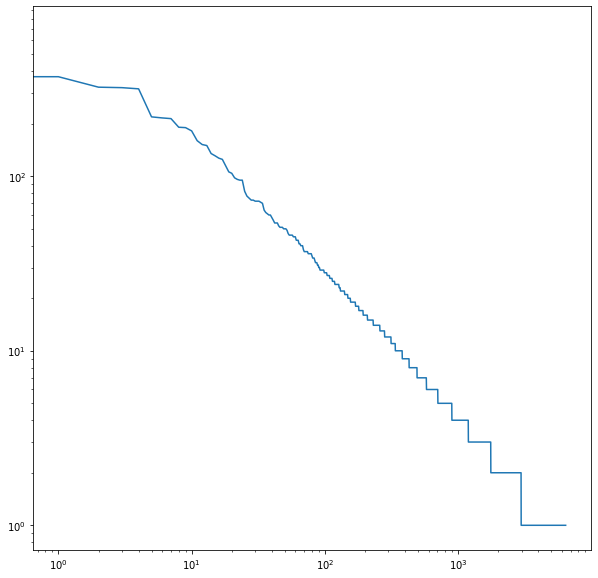

In [15]:
##### P6: Scale-free distribution p(k) = ∼k−α. #####
print("P6: Scale-free distribution p(k) = ∼k^{−α}.")
distri_grados = df_train_k_pos.RESOURCE.value_counts()
plt.figure(figsize=(10,10))
plt.plot(sorted(distri_grados,reverse=True))
#x1, y1 = [100, 700], [0.13, 0.015]
#x2, y2 = [1, 231], [3, 2]
#plt.plot(x1, y1, marker = 'o')
plt.yscale("log")
plt.xscale("log")
plt.show()
print()

In [62]:
user_network_test = user_network.copy()
user_network_test.es.select(weight_lt=0.1).delete()

In [63]:
user_network_test.summary()

'IGRAPH UNW- 1032 1326 -- \n+ attr: agentfor (v), name (v), role (v), specialty (v), team (v), uward (v), weight (e)'

34


Text(0, 0.5, 'P(k)')

<Figure size 432x288 with 0 Axes>

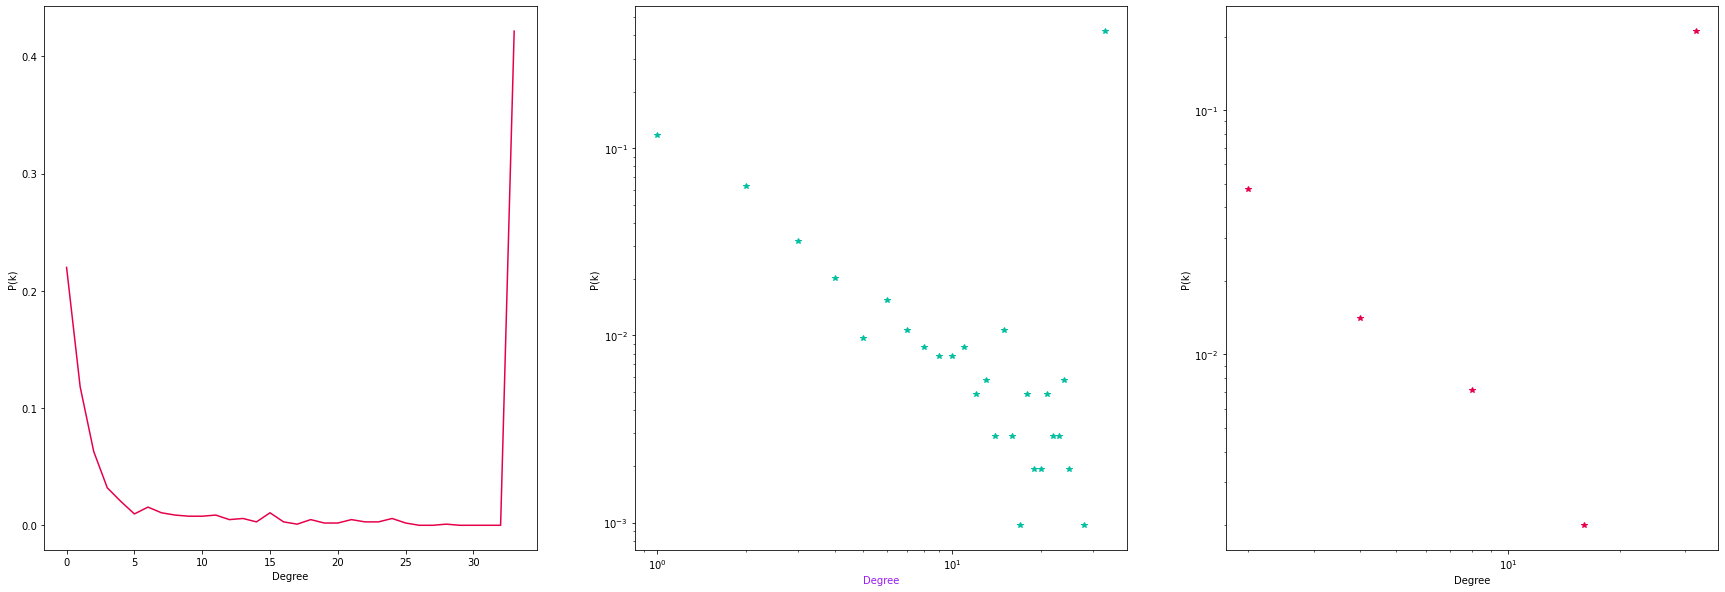

In [64]:
max_degree = max(user_network_test.degree())
print(max_degree)

# Crear una lista donde se almacena
degree_list = np.zeros(max_degree, dtype=int)

for node in user_network_test.vs():    
    degree_list[node.degree()-1] = (degree_list[node.degree()-1] + 1)

degree_list = degree_list / user_network_test.vcount()

plt.clf()
fig = plt.figure(figsize=(30, 10))     

plt.subplot(1, 3, 1)
plt.plot(degree_list, color="#e60049")
plt.xlabel('Degree')
plt.ylabel('P(k)')

plt.subplot(1, 3, 2)
plt.plot(range(max_degree), degree_list, color="#00bfa0", marker='*', ls='None')
plt.loglog()
plt.xlabel('Degree', color='#9b19f5')
plt.ylabel('P(k)')

plt.subplot(1, 3, 3)
n_log_bin = ceil(log2(max(user_network_test.degree())))
x_values, y_values = calculate_log_binning(degree_list, n_log_bin)
plt.plot(x_values, y_values, color='#e60049', marker="*", ls='None')
#C = y_values[0]
#alpha = 1.4
#x = np.arange(1,len(degree_list))
#y = C*np.power(x,-alpha)
#plt.plot(x, y, "b")
plt.loglog()
plt.xlabel('Degree')
plt.ylabel('P(k)')


In [16]:
density = user_network_test.density()
print("Density:", density)

avg_degree = sum(user_network_test.degree()) / user_network_test.vcount()
print("Avg. degree", avg_degree)

components = user_network_test.components()
print("Connected Components:", len(components))

Density: 0.002492499943608599
Avg. degree 2.5697674418604652
Connected Components: 505


In [65]:
user_network_test.write("HC-users-attrs.gml")

In [25]:
biggest_comp = components.subgraphs()[18]

34


Text(0, 0.5, 'P(k)')

<Figure size 432x288 with 0 Axes>

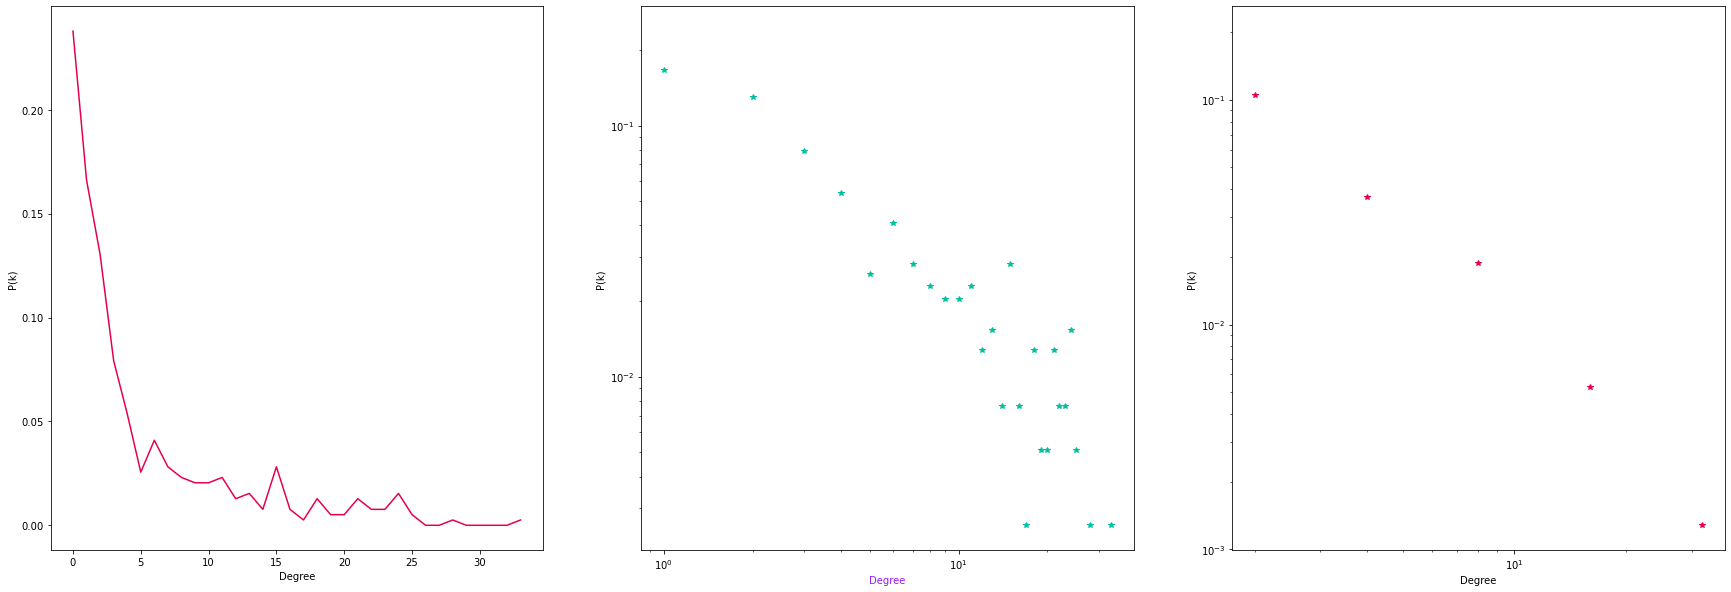

In [26]:
max_degree = max(biggest_comp.degree())
print(max_degree)

# Colors palette CATEGORICAL
# ["#ea5545", "#f46a9b", "#ef9b20", "#edbf33", "#ede15b", "#bdcf32", "#87bc45", "#27aeef", "#b33dc6"]
# ["#fd7f6f", "#7eb0d5", "#b2e061", "#bd7ebe", "#ffb55a", "#ffee65", "#beb9db", "#fdcce5", "#8bd3c7"] Pasteles
# [#e60049", "#0bb4ff", "#50e991", "#e6d800", "#9b19f5", "#ffa300", "#dc0ab4", "#b3d4ff", "#00bfa0"] Dutch

# Colors palette Secquence
# ["#115f9a", "#1984c5", "#22a7f0", "#48b5c4", "#76c68f", "#a6d75b", "#c9e52f", "#d0ee11", "#d0f400"]

# Crear una lista donde se almacena
degree_list = np.zeros(max_degree, dtype=int)

for node in biggest_comp.vs():    
    degree_list[node.degree()-1] = (degree_list[node.degree()-1] + 1)

degree_list = degree_list / biggest_comp.vcount()

plt.clf()
fig = plt.figure(figsize=(30, 10))     

plt.subplot(1, 3, 1)
plt.plot(degree_list, color="#e60049")
plt.xlabel('Degree')
plt.ylabel('P(k)')

plt.subplot(1, 3, 2)
plt.plot(range(max_degree), degree_list, color="#00bfa0", marker='*', ls='None')
plt.loglog()
plt.xlabel('Degree', color='#9b19f5')
plt.ylabel('P(k)')

plt.subplot(1, 3, 3)
n_log_bin = ceil(log2(max(biggest_comp.degree())))
x_values, y_values = calculate_log_binning(degree_list, n_log_bin)
plt.plot(x_values, y_values, color='#e60049', marker="*", ls='None')
#C = y_values[0]
#alpha = 1.4
#x = np.arange(1,len(degree_list))
#y = C*np.power(x,-alpha)
#plt.plot(x, y, "b")
plt.loglog()
plt.xlabel('Degree')
plt.ylabel('P(k)')

#plt.subplot(1, 3, 3)
#bins = np.logspace(0, 3.22, 12)
#plt.plot(bins[:-1], hist_norm, "r*")
#plt.plot(range(max_degree), degree_list, "b.")
#plt.loglog()
#plt.xlabel('Degree')
#plt.ylabel('P(k)')

In [ ]:
# Agregar attributos al grafo de usuarios.
# Aplicar detección de comunidades.
# Ver si genera comunidades con la estructura del grafo bipartito (circulos de colores del doc)
# Ver si genera comunidades con los mismo atribuos.